Using TensorFlow backend.


numpy: 1.13.3
keras: 2.0.8
sklearn: 0.19.1


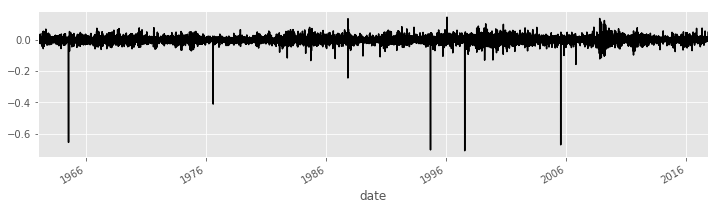

In [1]:
# https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/
# https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Keras_Cheat_Sheet_Python.pdf
# https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.wrappers.scikit_learn import KerasRegressor
import sklearn
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import matplotlib
import matplotlib.pyplot as plt
from timeit import default_timer
from data_prep import load_equity

print('numpy: ' + np.__version__)
print('keras: ' + keras.__version__)
print('sklearn: ' + sklearn.__version__)

matplotlib.style.use('ggplot')

cat_df = load_equity('CAT')

plt.figure(figsize=(12,3))
cat_df['lreturn'].plot(style='k-')
plt.show()

In [2]:
# set window size
lookback_length = 10

# fix random seed for reproducibility
seed = 7

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

X, y = create_dataset(cat_df['lreturn'].values[1:], look_back=lookback_length)
print(X.shape)

# save last 5% as test set
t = int(0.05 * len(X))
X_train, X_test = X[:-t,:], X[-t:,:]
y_train, y_test = y[:-t], y[-t:]
print(len(X_train) + len(X_test))

(14039, 10)
14039


In [3]:
def create_mlp_regressor(layers, optimizer='adam', standardize=False):
    def create_mlp():
        model = Sequential()

        model.add(Dense(layers[0], input_dim=lookback_length, activation='relu'))
        for l in layers[1:]:
            model.add(Dense(l, activation='relu'))
        model.add(Dense(1))

        model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
        return model
    
    estimator = create_mlp()
    
    print(estimator.summary())
    
#     estimator = KerasRegressor(build_fn=create_nn, nb_epoch=100, batch_size=5, verbose=0)
    
#     if standardize:
#         estimators = []
#         estimators.append(('standardize', StandardScaler()))
#         estimators.append(('mlp', estimator))
#         pipeline = Pipeline(estimators)
#         return pipeline

    return estimator
    
def test_mlp_architecture(layers, optimizer='adam'):
    start = default_timer()
    
    estimator = create_mlp_regressor(layers, optimizer)
    
    history = estimator.fit(X_train, y_train, batch_size=1, epochs=200, validation_data=(X_test,y_test), verbose=0)

    print('%0.0f min' % ((default_timer() - start)/60.0))

    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    
    print("MSE %f.5 train, %f.5 val" % (history.history['loss'][-1], history.history['val_loss'][-1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                264       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 889
Trainable params: 889
Non-trainable params: 0
_________________________________________________________________
None
47 min


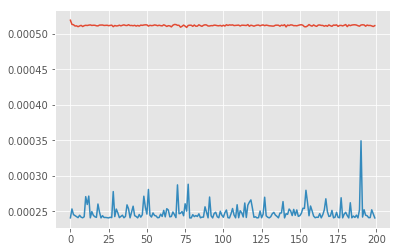

MSE 0.000512.5 train, 0.000241.5 val


In [4]:
np.random.seed(seed)

test_mlp_architecture([24, 24])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________
None
55 min


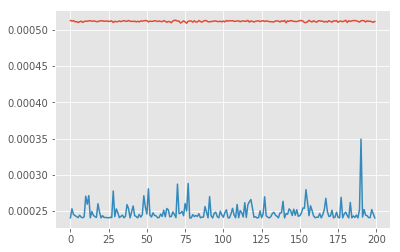

MSE 0.000512.5 train, 0.000241.5 val


In [5]:
np.random.seed(seed)

test_mlp_architecture([10, 10])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 6         
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________
None
60 min


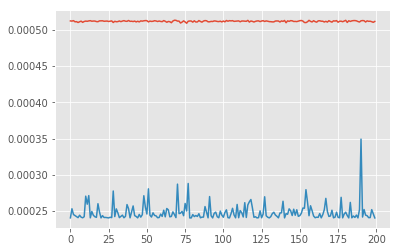

MSE 0.000512.5 train, 0.000241.5 val


In [6]:
np.random.seed(seed)

test_mlp_architecture([20, 5])